# Etudes des valeurs foncières Française
Liens: https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/

In [1]:
# Gather Latitude Longitude from Google Map (time/cost consuming)
add_lat_long = False

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import glob
from datetime import datetime

pd.options.display.max_columns = None

## Chargement du fichiers des valeurs foncières

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y') # 03/01/2018
def_types = {#'Code postal': 'category',
             #'B/T/Q': 'category',
             #'Nature mutation': 'category',
             #'Type de voie': 'category',
             #'Voie': 'category',
             #'Commune': 'category',
             #'Code departement': 'category',
             #'Type local': 'category',
             #'Nature culture': 'category',
             #'Nature culture speciale': 'category',
             
             'No voie': 'Int64',
             'Surface Carrez du 1er lot':'Float16',
             'Surface Carrez du 2eme lot':'Float16',
             'Surface Carrez du 3eme lot':'Float16',
             'Surface Carrez du 4eme lot':'Float16',
             'Surface Carrez du 5eme lot':'Float16',
             'Nombre de lots':'Int16',
             'Nombre de lots':'Int16',
             'Surface reelle bati': 'Float32',
             'Nombre pieces principales': 'Int8',
             'Surface terrain':'Float32'
            }
col_exclude = ['Code service CH', 'Reference document', '1 Articles CGI',
               '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI', 'Identifiant local',
               'Prefixe de section', 'Section', 'No plan',
               'No Volume','No disposition','Code type local', 'Code voie', 
               '5eme lot', '4eme lot', '3eme lot', '2eme lot', '1er lot']
all_files = glob.glob("data/*.txt")
#df = pd.concat((pd.read_csv(f, sep='|', decimal=",", dtype=def_types, parse_dates=['Date mutation'], date_parser=dateparse, usecols=lambda col: col not in col_exclude) for f in all_files))
df = pd.read_csv('data/valeursfoncieres-2019.txt', sep='|', decimal=",", dtype=def_types, parse_dates=['Date mutation'], date_parser=dateparse,usecols=lambda col: col not in col_exclude)

/Users/odyssee/opt/anaconda3/envs/jupy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Renomme les colonnes

In [4]:
import unidecode

columns = {}
for index, column_name in enumerate(df.columns):
    columns[column_name] = unidecode.unidecode(column_name.replace(' ','_').replace('\'','_').lower())
df.rename(columns=columns, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017154 entries, 0 to 1017153
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   date_mutation               1017154 non-null  datetime64[ns]
 1   nature_mutation             1017154 non-null  object        
 2   valeur_fonciere             1004369 non-null  float64       
 3   no_voie                     606327 non-null   Int64         
 4   b/t/q                       44359 non-null    object        
 5   type_de_voie                593091 non-null   object        
 6   voie                        1004961 non-null  object        
 7   code_postal                 1004998 non-null  float64       
 8   commune                     1017154 non-null  object        
 9   code_departement            1017154 non-null  object        
 10  code_commune                1017154 non-null  int64         
 11  surface_carrez_du_1er_lo

## Supression des colonnes sans données

On gardes les colonnes sans valeurs foncières car elles peuvent liées à d'autre transaction

In [6]:
# Suppression des lignes où il n'y a pas de 'valeurs foncières'
#indexNames = df[df['valeur_fonciere'].isnull()].index
#df.drop(indexNames, inplace=True)

## Recherche des doublons

In [7]:
#df[df.duplicated(keep=False)]

In [8]:
# Drop duplicates
initial_length = len(df)
df.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(df)))

Suppression des doublons: 98514


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918640 entries, 0 to 1017153
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_mutation               918640 non-null  datetime64[ns]
 1   nature_mutation             918640 non-null  object        
 2   valeur_fonciere             907760 non-null  float64       
 3   no_voie                     532676 non-null  Int64         
 4   b/t/q                       38718 non-null   object        
 5   type_de_voie                515373 non-null  object        
 6   voie                        912188 non-null  object        
 7   code_postal                 912218 non-null  float64       
 8   commune                     918640 non-null  object        
 9   code_departement            918640 non-null  object        
 10  code_commune                918640 non-null  int64         
 11  surface_carrez_du_1er_lot   89372 non-

## Nettoyage des données simple

In [10]:
def missing_values_assessment(df):
    nan_values = df.isnull().sum().sum()
    print('Nombre d\'observations: {:,}'.format(len(df.index)))
    print('Nombre de valeurs: {:,}'.format(df.size))
    print('Valeurs manquantes: {:,}'.format(nan_values))
    print('Qualité des données: {}%'.format(100-round((nan_values/df.size)*100,2)))
    print('Type de données:\n {}%'.format(df.dtypes.value_counts()))
    analysis = {'Manquant': df.isnull().sum(),
                'Manquant %':round((df.isnull().sum()/len(df))*100, 2),
                'Type':df.dtypes
               }
    return pd.DataFrame(analysis)

#### Analyse des données manquantes

In [11]:
missing_values_assessment(df).sort_values('Manquant %', ascending=False)

Nombre d'observations: 918,640
Nombre de valeurs: 21,128,720
Valeurs manquantes: 8,875,806
Qualité des données: 57.99%
Type de données:
 object            9
float16           5
float32           2
float64           2
Int64             1
Int16             1
int64             1
datetime64[ns]    1
Int8              1
dtype: int64%


,Manquant,Manquant %,Type
surface_carrez_du_5eme_lot,918436,99.98,float16
surface_carrez_du_4eme_lot,918099,99.94,float16
surface_carrez_du_3eme_lot,916551,99.77,float16
surface_carrez_du_2eme_lot,896223,97.56,float16
b/t/q,879922,95.79,object
nature_culture_speciale,876904,95.46,object
surface_carrez_du_1er_lot,829268,90.27,float16
nombre_pieces_principales,434277,47.27,Int8
surface_reelle_bati,434277,47.27,float32
type_local,433658,47.21,object


In [12]:
# Remplissage des mètres Carrez manquant avec zéro
#df = df[df['Nombre de lots']<=5].dropna(how='all', axis=1)
df['surface_carrez_du_5eme_lot'].fillna(0, inplace=True)
df['surface_carrez_du_4eme_lot'].fillna(0, inplace=True)
df['surface_carrez_du_3eme_lot'].fillna(0, inplace=True)
df['surface_carrez_du_2eme_lot'].fillna(0, inplace=True)
df['surface_carrez_du_1er_lot'].fillna(0, inplace=True)
df['surface_reelle_bati'].fillna(0, inplace=True)
df['surface_terrain'].fillna(0, inplace=True)
df['nombre_pieces_principales'].fillna(0, inplace=True)

#### Analyse graphique des données manquantes

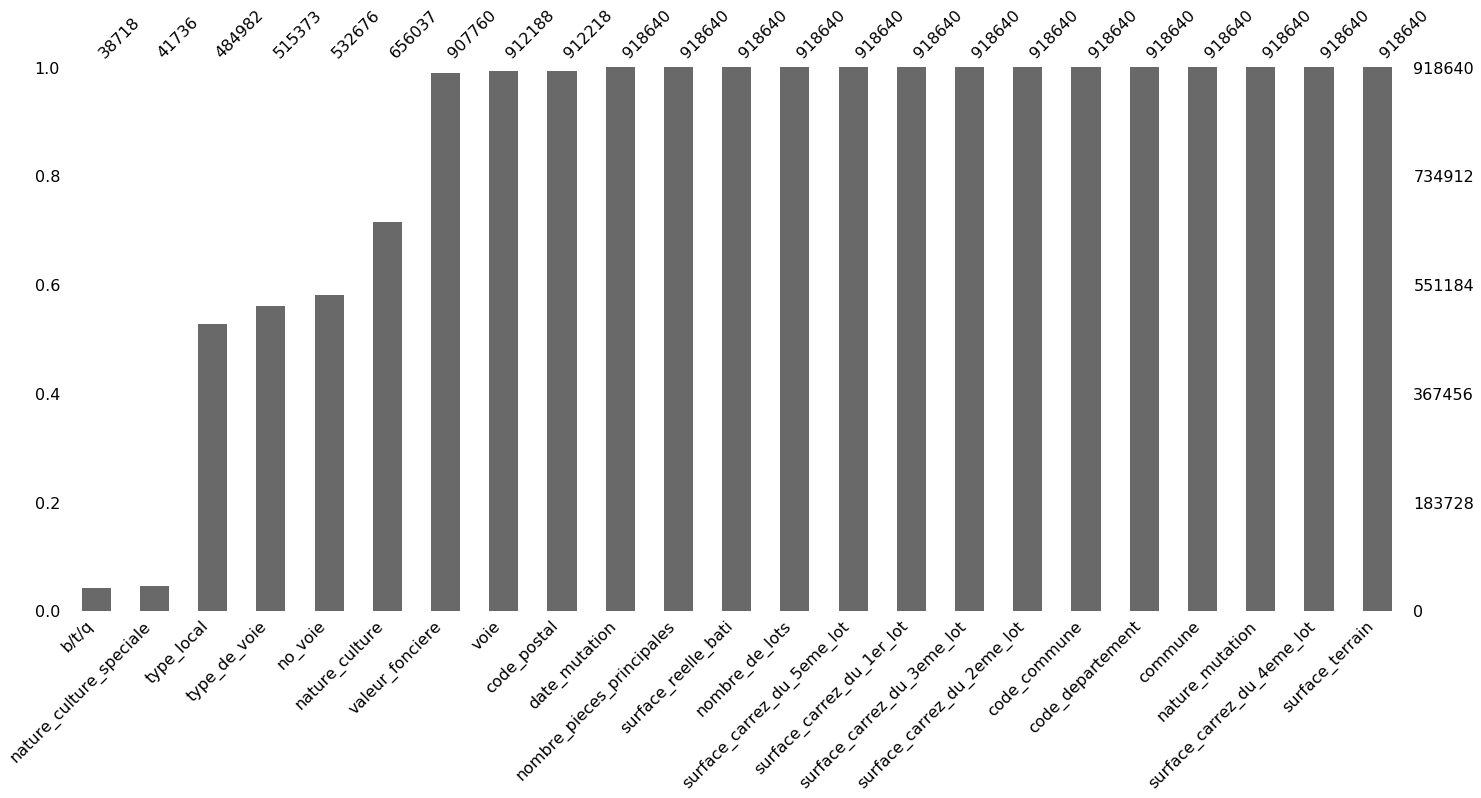

In [13]:
msno.bar(df, sort='ascending')

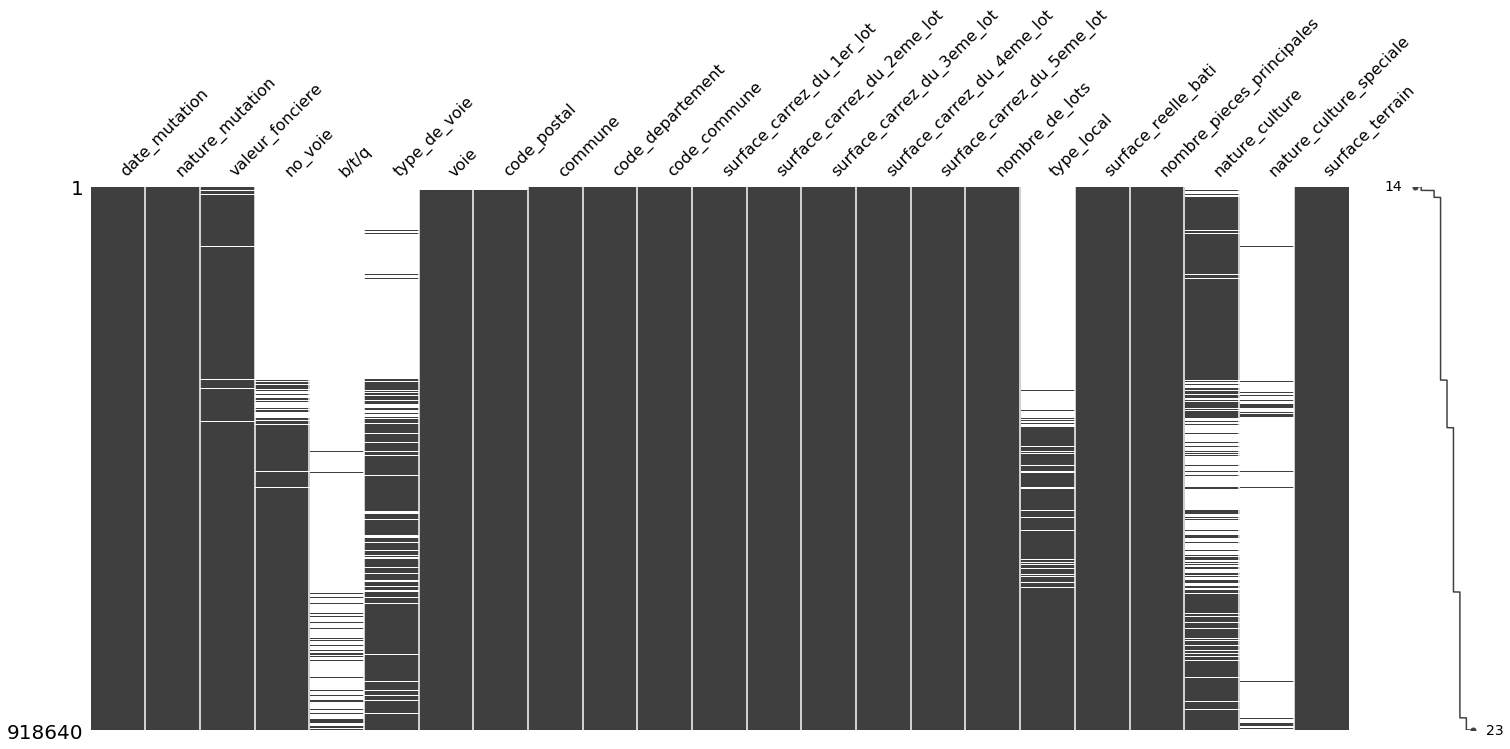

In [14]:
msno.matrix(df, sort='ascending')

## Nettoyage de données fonctionnelles

In [15]:
# Colonne 'B/T/Q'
df.loc[df['b/t/q'].isin([',','/','*',"'",'-','.']), ['b/t/q']] = np.NaN

In [16]:
# Colonne Code Département
df['code_departement'] = df['code_departement'].astype('str')
df.loc[df['code_departement']=='2A', ['code_departement']] = '120'
df.loc[df['code_departement']=='2B', ['code_departement']] = '121'
df['code_departement'] = df['code_departement'].astype(np.int16) # Converti en int16 pour la mémoire

In [17]:
# Colonne code commune
df['code_commune'] = df['code_commune'].astype(np.int16)

In [18]:
## Formatage du code postal
df.code_postal=df.code_postal.apply(lambda x: '0{}'.format(x) if len(str(x))==4 else x)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918640 entries, 0 to 1017153
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_mutation               918640 non-null  datetime64[ns]
 1   nature_mutation             918640 non-null  object        
 2   valeur_fonciere             907760 non-null  float64       
 3   no_voie                     532676 non-null  Int64         
 4   b/t/q                       38702 non-null   object        
 5   type_de_voie                515373 non-null  object        
 6   voie                        912188 non-null  object        
 7   code_postal                 912218 non-null  float64       
 8   commune                     918640 non-null  object        
 9   code_departement            918640 non-null  int16         
 10  code_commune                918640 non-null  int16         
 11  surface_carrez_du_1er_lot   918640 non

In [20]:
missing_values_assessment(df).sort_values('Manquant %', ascending=False)

Nombre d'observations: 918,640
Nombre de valeurs: 21,128,720
Valeurs manquantes: 3,266,088
Qualité des données: 84.53999999999999%
Type de données:
 object            8
float16           5
int16             2
float32           2
float64           2
Int64             1
Int16             1
datetime64[ns]    1
Int8              1
dtype: int64%


,Manquant,Manquant %,Type
b/t/q,879938,95.79,object
nature_culture_speciale,876904,95.46,object
type_local,433658,47.21,object
type_de_voie,403267,43.90,object
no_voie,385964,42.01,Int64
nature_culture,262603,28.59,object
valeur_fonciere,10880,1.18,float64
voie,6452,0.70,object
code_postal,6422,0.70,float64
date_mutation,0,0.00,datetime64[ns]


## Sauvegarde des données finales

In [21]:
df.to_csv(r'data/valeursfoncieres-clean-df.csv', index = None, header=True)

## Extraction des données pour une analyse ciblée

In [22]:
df_maisons = df[(df['type_local'].isin(['Maison']))&(df['nature_mutation']=='Vente')]
len(df_maisons.index)

201244

In [23]:
df_maisons_simple = df_maisons.groupby(['date_mutation','valeur_fonciere']).filter(lambda x: len(x) == 1)
len(df_maisons_simple.index)

46578

In [24]:
df_maisons_simple['surface_carrez'] = df_maisons_simple['surface_carrez_du_1er_lot']+ df_maisons_simple['surface_carrez_du_2eme_lot'] + df_maisons_simple['surface_carrez_du_3eme_lot'] + df_maisons_simple['surface_carrez_du_4eme_lot'] + df_maisons_simple['surface_carrez_du_5eme_lot']
#df_maisons_simple['surface_carrez'].apply(lambda x: x if x>0 else df_maisons_simple['surface_reelle_bati'])
df_maisons_simple['surface_carrez'] = df_maisons_simple.loc[df_maisons_simple['surface_carrez'] ==0, 'surface_carrez'] = df_maisons_simple['surface_reelle_bati']



In [25]:
df_maisons_simple['prix_m2'] = df_maisons_simple['valeur_fonciere']/df_maisons_simple['surface_carrez']

In [26]:
df_maisons_simple.sort_values(by=['prix_m2']).tail(20)

,date_mutation,nature_mutation,valeur_fonciere,no_voie,b/t/q,type_de_voie,voie,code_postal,commune,code_departement,code_commune,surface_carrez_du_1er_lot,surface_carrez_du_2eme_lot,surface_carrez_du_3eme_lot,surface_carrez_du_4eme_lot,surface_carrez_du_5eme_lot,nombre_de_lots,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,nature_culture_speciale,surface_terrain,surface_carrez,prix_m2
763043,2019-01-17,Vente,3784560.0,35,NaN,RUE,DE THANN,78500.0,SARTROUVILLE,78,586,0.0000,0.0,0.0,0.0,0.0,0,Maison,48.0,3,NaN,NaN,0.0,48.0,7.884500e+04
33095,2019-03-26,Vente,2590000.0,916,NaN,BD,DU MERCANTOUR,6200.0,NICE,6,88,0.0000,0.0,0.0,0.0,0.0,0,Maison,32.0,2,S,NaN,1925.0,32.0,8.093750e+04
999281,2019-05-29,Vente,55000000.0,38,NaN,RUE,BARBET DE JOUY,75007.0,PARIS 07,75,107,0.0000,0.0,0.0,0.0,0.0,0,Maison,667.0,20,S,NaN,969.0,667.0,8.245877e+04
958926,2019-01-30,Vente,6702984.0,77,NaN,AV,DE PARIS,94800.0,VILLEJUIF,94,76,0.0000,0.0,0.0,0.0,0.0,0,Maison,75.0,4,S,NaN,1634.0,75.0,8.937312e+04
909129,2019-06-28,Vente,9108000.0,64,NaN,BD,SAINT MICHEL,91150.0,ETAMPES,91,223,0.0000,0.0,0.0,0.0,0.0,0,Maison,100.0,4,S,NaN,385.0,100.0,9.108000e+04
945840,2019-02-18,Vente,1700000.0,1,NaN,RUE,SEVERINE,93600.0,AULNAY SOUS BOIS,93,5,0.0000,0.0,0.0,0.0,0.0,0,Maison,18.0,1,S,NaN,354.0,18.0,9.444444e+04
904112,2019-01-24,Vente,8952003.0,4,NaN,RUE,DE LA MARE A BLOT,91220.0,LE PLESSIS PATE,91,494,0.0000,0.0,0.0,0.0,0.0,0,Maison,93.0,4,S,NaN,40872.0,93.0,9.625810e+04
775618,2019-01-24,Vente,8511580.0,9004,NaN,AV,DE LA MAULDRE,78680.0,EPONE,78,217,0.0000,0.0,0.0,0.0,0.0,0,Maison,87.0,4,S,NaN,31295.0,87.0,9.783425e+04
472167,2019-04-25,Vente,2972249.0,9002,NaN,RUE,LESPINASSE,47000.0,AGEN,47,1,0.0000,0.0,0.0,0.0,0.0,0,Maison,27.0,1,S,NaN,4350.0,27.0,1.100833e+05
268637,2019-04-11,Vente,8300000.0,45,NaN,RUE,CHARLES MARIONNEAU,33000.0,BORDEAUX,33,63,0.0000,0.0,0.0,0.0,0.0,0,Maison,69.0,3,S,NaN,2398.0,69.0,1.202899e+05


In [27]:
len(df_maisons_simple.index)

46578

In [28]:
len(df_maisons_simple[df_maisons_simple['surface_reelle_bati']==0].index)

0

In [29]:
pd.options.display.float_format = "{:.2f}".format
df_maisons_simple['valeur_fonciere'].describe()

count       46578.00
mean       296353.15
std       2629947.03
min             1.00
25%        121500.00
50%        209575.00
75%        335752.50
max     400000000.00
Name: valeur_fonciere, dtype: float64

In [50]:
quant_low = df_maisons_simple['valeur_fonciere'].quantile(0.005)
quant_high = df_maisons_simple['valeur_fonciere'].quantile(0.999)
qty_low = len(df_maisons_simple[df_maisons_simple['valeur_fonciere']<quant_low].index)
qty_high = len(df_maisons_simple[df_maisons_simple['valeur_fonciere']>quant_high].index)
print('{}({}) < mean < {}({})'.format(quant_low, qty_low, quant_high, qty_high))


2500.0(227) < mean < 4142300.00000025(47)


8652

In [38]:
len(df[df['valeur_fonciere']>df['valeur_fonciere'].quantile(0.99)].index)

9041

KeyboardInterrupt: 

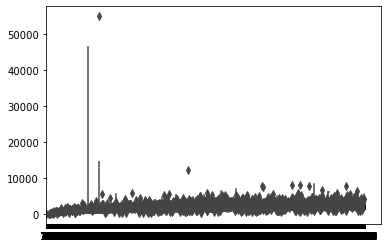

In [30]:
import seaborn as sns
#df_maisons_simple.boxplot(column=['valeur_fonciere'])
#g = sns.boxplot(x="valeur_fonciere", y="prix_m2", data=df_maisons_simple)
#g.set_yscale("log")
#g

In [ ]:
df_maisons_simple.info()

In [ ]:
df_maisons_simple.drop(['date_mutation','nature_mutation','no_voie','b/t/q','type_de_voie','voie','code_commune',
        'surface_carrez_du_1er_lot','surface_carrez_du_2eme_lot','surface_carrez_du_3eme_lot',
        'surface_carrez_du_4eme_lot','surface_carrez_du_5eme_lot','nombre_de_lots','nature_culture',
        'nature_culture_speciale','surface_carrez','prix_m2'], axis=1, inplace=True)

In [ ]:
df_maisons_simple = df_maisons_simple.dropna(axis = 0, how ='any')
missing_values_assessment(df_maisons_simple).sort_values('Manquant %', ascending=False)

In [ ]:
df_maisons_simple.to_csv(r'data/maisons_simples_ML_READY.csv', index = None, header=True)